<a href="https://colab.research.google.com/github/ajayostawal/Seq2Seq_Eng_to_French/blob/main/Seq2Seq_LSTM_Teacher_Forcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Machine Translator of English to hindi using Encoder and Decoder with LSTM cell states. 
we have data which is in the form of text of sequence and our model should convert it into other language .
1] Any machine algorithm takes input in numerical form so our first step is to convert text into vector form . so i have use vocab_size as one hot encoding to convert input raw data into vocab_size dimension .So our input data which is converted into vector of 2D dimension i.e input_data = (number_samples , max_length)
but our LSTM algorithm require 3D data so we use word embedding to convert 2D -> 3D i.e embed_layer = embedding(num_samples, sequence_length, embedding_dims).

2]In seq2seq we use encoder and decoder so we separate it first 

2]a]ENCODER

In LSTM encoder ,  we have sequence as input which is tokenized and each word(token) is process at separate time-stamp t i.e each word is process at different time-step ,where output of each cell state(time t) is given input to next cell state(time t+1).
In LSTM we have two imputs and one output i.e inputs : the current word(t) and previous layer(t-1) output ,for each cell state we have separate output but , 
IN ENCODER : we skip all the cell state outputs and take only one single output at end of sentence (we call that output as context vector)
The context vector has the responsibility of encoding all the information which is process at different time-stamp and send to decoder.

2]b] Decoder
In decoder the output is predicted at t+1 timestamp so for each input sequence we add <start> and <end> token .so the decoder input will be current state(<start>) and output of encoder(context vector) .At output we use softmax activation function which gives  probablity of word and max probablity is the output of that cell state and that output is given to next cell state as input and the contect vector output is given to next cell state at t+1 time stamp to predict next word.for eg.
i want to predict 2nd word output and i only have output of previous layer as current input and the previous layer output(context vector) so the cell state uses the context vector and identifies where is input process in encoder and comes back at decoder 2nd place ,but it require lots of processing becz the decoder cell state goes from all the previous time stamp and find 2nd word in encoder ,it require lots of time .this process continous till we get <EOS> .
we will see in next session about disadvantages of context vector and how it effects decoder output.
Now we perform seq2seq using LSTM encoder and decoder on english to hindi translation.
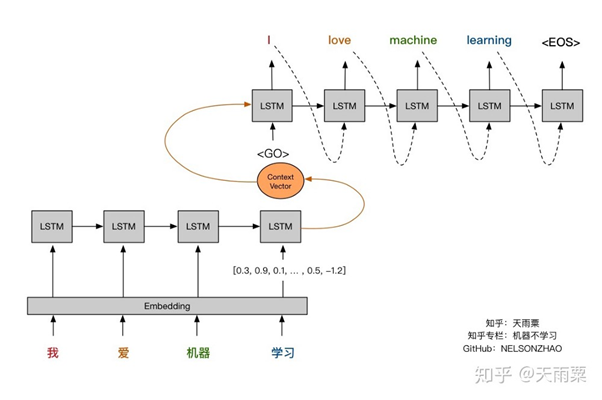

Encoder-Decoder with simple fixed context vector

In [ ]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Global parameters
#root folder
root_folder='.'
#data_folder='.'
#data_folder_name='content'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 15  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [ ]:
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial
# in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [ ]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[1000])
print(target_data[1000])
print(target_input_data[1000])

are you in ?
¿ estas dentro ? <eos>
<sos> ¿ estas dentro ?


In [ ]:
#See why we use filter
dummy=['I am Raj .']
t=Tokenizer()
t.fit_on_texts(dummy)
t.texts_to_sequences(dummy)

[[1, 2, 3]]

In [ ]:
# Create a tokenizer for the input texts and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[15000])
print(input_sequences[15000])

Max Input Length:  8
she didn t answer .
[27, 90, 10, 238, 1]


In [ ]:
# tokenize the outputs
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[15000])
print(target_sequences[15000])
print(target_input_data[15000])
print(target_sequences_inputs[15000])

Max Target Length:  15
ella no respondio . <eos>
[29, 8, 831, 1, 2]
<sos> ella no respondio .
[3, 29, 8, 831, 1]


In [ ]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 3664 unique input tokens.
Found 7168 unique output tokens.


In [ ]:

# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (20000, 8)
encoder_inputs[0]: [31  1  0  0  0  0  0  0]
decoder_inputs[0]: [ 3 99  1  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 15)


In [ ]:
len(input_data)==len(target_data)==len(target_input_data)


True

In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_inputs, decoder_targets))
for element in dataset:
  print(element)
  print(len(element))
  print(type(element[0]))
  print(type(element[1]))
  print(type(element[2]))
  break
#Just to see what the generator gives

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([31,  1,  0,  0,  0,  0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(15,), dtype=int32, numpy=
array([ 3, 99,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)>, <tf.Tensor: shape=(15,), dtype=int32, numpy=
array([99,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)>)
3
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)
#Drop remainder=True drops batches with size < batch_size

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    # Define the embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Define the RNN layer, LSTM
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True) 

  def call(self,input_sequence,states):
    #Embed input sequence
    embed=self.embedding(input_sequence) 
    #LSTM
    output, state_h, state_c = self.lstm(embed, initial_state=states) #h-memory c-carry
    return output, state_h, state_c

  def init_states(self, batch_size):
    # Return a all 0s initial states
    return (tf.zeros([batch_size, self.hidden_dim]),tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Decoder,self).__init__()
    self.hidden_dim=hidden_dim
    self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True)
    self.dense=tf.keras.layers.Dense(vocab_size)

  def call(self,input_sequence,state_tuple):
    embed=self.embedding(input_sequence)
    lstm_out,state_h,state_c=self.lstm(embed, initial_state=state_tuple)
    logits=self.dense(lstm_out) #Softmax is covered in the loss function
    return logits, state_h, state_c

In [ ]:
print("Embedding dimension "+str(EMBEDDING_DIM))
print("Hidden dimension "+str(HIDDEN_DIM))
print("Batch Size "+str(BATCH_SIZE))

Embedding dimension 128
Hidden dimension 1024
Batch Size 64


In [ ]:

#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_outputs = len(word2idx_outputs) + 1

encoder=Encoder(num_words_inputs,EMBEDDING_DIM,HIDDEN_DIM)

initial_states = encoder.init_states(1) # 1 X 1024 (HIDDEN_DIM). All zeroes

test_encoder_output = encoder(tf.constant([[1, 23, 4, 5, 0, 0]]), initial_states) 

#  Outputs  Note 1 is batch size here 

# 0 For each unit an output hence in total 1 X Len(sentence) X HIDDEN_DIM
# 1 H-memory 1 X HIDDEN_DIM
# 2 C-memory 1 X HIDDEN_DIM

decoder=Decoder(num_words_outputs,EMBEDDING_DIM,HIDDEN_DIM)

de_initial_state = test_encoder_output[1:] # H-memory & C-cell

test_decoder_output= decoder(tf.constant([[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)

test_decoder_output
#  Outputs  Note 1 is batch size here 

# 0 For each unit, for each word in vocab (7169 size) a probability thus batch_size X len_seq X vocab_size (output)
# 1 H-memory 1 X HIDDEN_DIM
# 2 C-memory 1 X HIDDEN_DIM

(<tf.Tensor: shape=(1, 8, 7169), dtype=float32, numpy=
 array([[[ 2.83489609e-03, -1.97418197e-03, -1.21690182e-03, ...,
           1.10796234e-03, -1.26094674e-03,  9.60833102e-04],
         [ 2.12052744e-03, -2.38688197e-03, -1.14626158e-03, ...,
           1.59905781e-03,  3.56562086e-04,  1.55509653e-04],
         [ 2.12519476e-03, -1.75642234e-03, -5.29158220e-04, ...,
           2.25258828e-03,  1.24926423e-03, -7.56185967e-04],
         ...,
         [ 7.83751777e-04, -1.13471644e-04, -1.81015627e-03, ...,
           2.12728279e-03,  2.34552356e-03, -5.41790854e-04],
         [-1.06661319e-04,  3.57425364e-04, -1.49424491e-03, ...,
           2.93425424e-03,  2.08419398e-03, -1.15000876e-06],
         [-7.14377325e-04,  7.57954083e-04, -1.24606164e-03, ...,
           3.38926865e-03,  1.87957170e-03,  4.18331067e-04]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[ 0.00235253, -0.00380763, -0.00342855, ..., -0.00145083,
          0.00190319

In [ ]:

def loss_func(targets,logits):
  #SparseCategoicalCrossentropy doesn't require targets to be one hot encoded & is more efficient than categorical cross entropy when num_classes is huge
  crossentropy=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #If from_logits=True no need to apply softmax in dense layer
  #Masking
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64) #Convert boolean to int
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, max length, vocab size
    # y_true shape is batch_size, max length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32') #returns batch_size,max length
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32') #Shape batch_size,max len 
    n_correct = K.sum(mask * correct)  #Sums across all axes if not specified, thus shape is ()
    n_total = K.sum(mask) #Real length of sequences in entire batch
  
    return n_correct / n_total

#Here the accuracy took sum (correctly_predicted tokens in a batch) / sum(total tokens in that batch )

In [ ]:

# Use the @tf.function decorator to take advance of static graph computation
@tf.function

#TRAINS 1 BATCH

def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of 2 arrays of shape [batch_size, hidden_dim] each.
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        de_states = en_outputs[1:]
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [ ]:
dataset.take(-1)


<TakeDataset shapes: ((64, 8), (64, 15), (64, 15)), types: (tf.int32, tf.int32, tf.int32)>

In [ ]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    '''
    dataset is of type tensorflow.python.data.ops.dataset_ops.BatchDataset 
    '''
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 3.1258 Acc:0.0000
Epoch 1 Batch 100 Loss 1.5473 Acc:0.3784
Epoch 1 Batch 200 Loss 1.4400 Acc:0.4086
Epoch 1 Batch 300 Loss 1.3126 Acc:0.4602
Time taken for 1 epoch 720.3396 sec

Epoch 2 Batch 0 Loss 1.1900 Acc:0.4437
Epoch 2 Batch 100 Loss 1.1827 Acc:0.4854
Epoch 2 Batch 200 Loss 1.2053 Acc:0.4470
Epoch 2 Batch 300 Loss 1.1317 Acc:0.4886
Time taken for 1 epoch 719.7901 sec

Epoch 3 Batch 0 Loss 0.9424 Acc:0.5180
Epoch 3 Batch 100 Loss 1.0278 Acc:0.4928
Epoch 3 Batch 200 Loss 0.9434 Acc:0.5178
Epoch 3 Batch 300 Loss 0.9174 Acc:0.5530
Time taken for 1 epoch 720.9447 sec

Epoch 4 Batch 0 Loss 0.7412 Acc:0.6119
Epoch 4 Batch 100 Loss 0.8421 Acc:0.5628
Epoch 4 Batch 200 Loss 0.8495 Acc:0.5588
Epoch 4 Batch 300 Loss 0.8257 Acc:0.5829
Time taken for 1 epoch 723.6576 sec

Epoch 5 Batch 0 Loss 0.6568 Acc:0.6101
Epoch 5 Batch 100 Loss 0.6642 Acc:0.6163
Epoch 5 Batch 200 Loss 0.7247 Acc:0.5950
Epoch 5 Batch 300 Loss 0.6838 Acc:0.6158
Time taken for 1 epoch 704.0394 sec

Epoch

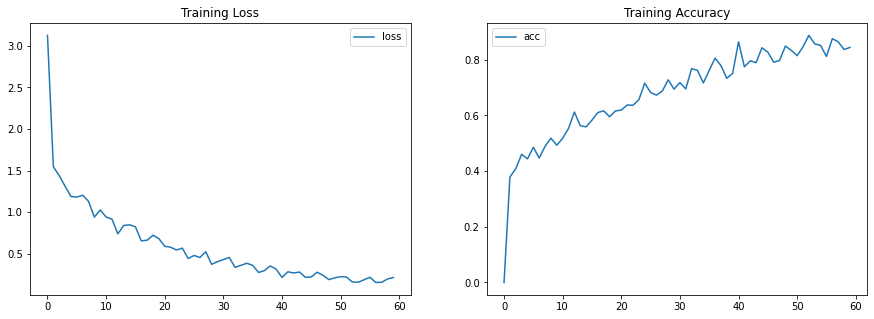

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:

checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def predict(input_text,input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

In [ ]:
predict(None,input_max_len,tokenizer_inputs, word2idx_outputs, idx2word_outputs)


it s not the same .
[[  7   8  33  14 905   1   0   0]]
no es la misma cosa . <eos>


In [ ]:
predict(input_data[17829],input_max_len,tokenizer_inputs, word2idx_outputs, idx2word_outputs)


i m not dead , am i ?
[[  2  13  33 302  49  59   2   5]]
no estoy muerto , ¿ no ? <eos>
